In [1]:
# Dependencias Generales
import os
import gc
import nibabel as nib
import random
import numpy as np
import matplotlib.pyplot as plt
import time
import psutil

# Dependencias de PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split

# Dependencias de Fastai
from fastai.learner import Learner
from fastai.data.core import DataLoaders
from fastai.data.load import DataLoader
from fastai.losses import L1LossFlat# MAE Loss for flatten (lineal)
from fastai.metrics import mae, BalancedAccuracy, accuracy
from fastai.test_utils import *
from fastai.vision.all import *

from sklearn.decomposition import PCA
import timm

In [2]:
# Fijar la semilla de PyTorch
torch.manual_seed(42)

# Fijar la semilla de NumPy
np.random.seed(42)

# Preprocesado

In [3]:
# Leer los dataFrames con las rutas y los datos
train = pd.read_csv('/kaggle/input/partition/trainAtlas.csv')
valid = pd.read_csv('/kaggle/input/partition/validAtlas.csv')
test = pd.read_csv('/kaggle/input/partition/testAtlas.csv')

### Normalizado de Datos

In [4]:
standard_normalize = lambda array: (array - np.mean(array)) / np.std(array) if np.std(array) != 0 else array - np.mean(array)

### Preparación del encoder.

In [5]:
class BraTS(Dataset):
  """
    Permite la lectura de los datos y etiquetas.
    Combina ambos para formar un tensor el cual va a ser pasado a un dataloader.
  """
  def __init__(self, atlas, transform=None):
    """
      Constructor de la clase dataset.

      Args:
      atlas (DataFrame): Frame de datos que contiene las rutas a cada ejemplo, el nº de slice y su etiqueta.
      transform (bool, optional): Aplicar transformaciones a las imágenes. Por defecto, no.

    """
    super(BraTS, self).__init__()
    self.atlas = atlas
    self.transform = transform
    self.mri_dtype = torch.float32

  def __len__(self):
    """
      Devuelve el tamaño del dataset
    """
    return len(self.atlas)

  def __getitem__(self, index):

    """
     Devuelve un elemento del dataset

    """
    
    # Obtener los paths de cada imagen
    img_paths = self.atlas.iloc[index][['ruta_t1c', 'ruta_t1n', 'ruta_t2f']].tolist()
    slice_num = self.atlas.iloc[index]['slice']

    # Obtener las imágenes de cada prueba 
    X = np.zeros((240, 240, 3))
    for idx, img_path in enumerate(img_paths): # Combinar cada slice de las 4 pruebas en 4 canales
      current_img = nib.load(img_path).dataobj[..., slice_num]       
      X[:, :, idx] += standard_normalize(current_img)
        
    x = torch.from_numpy(X.T).type(self.mri_dtype)
    y = torch.from_numpy(X.T).type(self.mri_dtype)
    
    del current_img
    del X

    return x, y

In [6]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class DownConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownConv, self).__init__()
        self.sequence = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        return self.sequence(x)

class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()
        self.sequence = nn.Sequential(
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2),
            ConvBlock(in_channels, out_channels)
        )

    def forward(self, x):
        return self.sequence(x)

class UpConvResize(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConvResize, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=8, stride=1)
        )

    def forward(self, x):
        return self.block(x)

In [7]:
# Cargar el modelo preentrenado
xception = timm.create_model('xception', pretrained=True)

class ResidualAutoencoder(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(ResidualAutoencoder, self).__init__()
        
        self.encoder = nn.ModuleList([
            *list(xception.children())[:-2] # Tomar todas las capas excepto las últimas dos (avgpool y fc)
        ]) 

        self.bottleneck = ConvBlock(2048, 1024) 
        
        self.decoder = nn.ModuleList([
            UpConvResize(1024, 512),
            UpConv(512, 256),
            UpConv(256, 128),
            UpConv(128, 64)
        ])
        
        self.output = nn.Sequential(
            UpConv(64, 32),
            nn.Conv2d(32, out_channels, kernel_size=1),
        )     
        
    def forward(self, x):
        # skips = []
        o = x
            
        for layer in self.encoder:
            o = layer(o)
            # skips.append(o)

        o = self.bottleneck(o)

        for layer in self.decoder:
            # o = torch.cat((skips[len(skips)-i-1],o), dim=1)
            o = layer(o)
            
        for layer in self.output:
            o = layer(o) 
            
        return o

/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_BS = BraTS(train)
valid_BS = BraTS(valid)

train_dl = DataLoader(train_BS, batch_size=32, shuffle=True, pin_memory=True)
valid_dl = DataLoader(valid_BS, batch_size=32, pin_memory=True)

autoencoder = ResidualAutoencoder().to(device)

In [9]:
# Crear el objeto Learner
dls = DataLoaders(train_dl, valid_dl)
learn = Learner(
    dls=dls,  
    model=autoencoder,      
    loss_func=L1LossFlat(),    
    metrics=[mae]
)

print(learn.summary())

ResidualAutoencoder (Input shape: 32 x 3 x 240 x 240)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 32 x 119 x 119 
Conv2d                                    864        True      
BatchNorm2d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 117 x 117 
Conv2d                                    18432      True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 128 x 59 x 59  
Conv2d                                    8192       True      
BatchNorm2d                               256        True      
Conv2d                                    576        True      
__________________________

#### Entrenamiento de la arquitectura utilizando MAE

epoch,train_loss,valid_loss,mae,time
0,0.102650,0.105854,0.105854,1:24:38
1,0.083989,0.089979,0.089979,1:28:34
2,0.074420,0.085525,0.085525,1:28:33
3,0.068684,0.071334,0.071334,1:30:09
4,0.063998,0.065802,0.065802,1:26:00
5,0.060919,0.063771,0.063771,1:27:03
6,0.060293,0.062978,0.062978,1:26:51


Better model found at epoch 0 with valid_loss value: 0.10585441440343857.


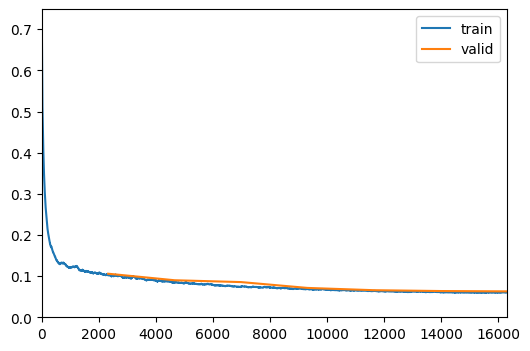

Better model found at epoch 1 with valid_loss value: 0.08997925370931625.
Better model found at epoch 2 with valid_loss value: 0.08552475273609161.
Better model found at epoch 3 with valid_loss value: 0.07133445143699646.
Better model found at epoch 4 with valid_loss value: 0.06580176949501038.
Better model found at epoch 5 with valid_loss value: 0.06377069652080536.
Better model found at epoch 6 with valid_loss value: 0.06297803670167923.


In [10]:
cbs = [SaveModelCallback(), ShowGraphCallback(), EarlyStoppingCallback(monitor='valid_loss', patience=3)]
n_epoch = 7

# Entrenar toda la red
learn.fit_one_cycle(n_epoch, cbs=cbs)

In [11]:
learn.save('/kaggle/working/fittingautoencodertotrain')

Path('/kaggle/working/fittingautoencodertotrain.pth')

### Cargando y validando el modelo

In [12]:
# model_path = Path('/kaggle/input/encoder2/fittingautoencodertotrain')

# Cargar los pesos
# learn.load(model_path)

In [13]:
# Realizar la validación
results = learn.validate(dl=valid_dl)
print("MAE:", results[1]) 

MAE: 0.06297803670167923


### Visualizando output del autoencoder

In [14]:
def visualizar_img(output: torch.Tensor, label: torch.Tensor, num: int):  
    nombres = ['Meningioma', 'Glioma', 'No Tumor']
    out_np = output.squeeze().numpy()
    label_np = label.squeeze().numpy()

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(out_np[2, :, :], cmap='gray') # Se 2 significa que se visualiza T2F
    axs[1].imshow(label_np[2, :, :], cmap='gray')
    
    plt.suptitle(f"Nº {num} {nombres[valid.iloc[num]['etiqueta']]}")
    plt.tight_layout()
    plt.show()

In [15]:
def visualizar_imgs():
    idx_ejemplos = random.sample(range(31900), 20)
    for i in idx_ejemplos:
        img_paths = valid.iloc[i][['ruta_t1c', 'ruta_t1n', 'ruta_t2f']].tolist()
        slice_num = valid.iloc[i]['slice']

        X = np.zeros((240, 240, 3))
        for idx, img_path in enumerate(img_paths): # Combinar cada slice de las 3 pruebas en 3 canales
                current_img = nib.load(img_path).dataobj[..., slice_num]
                X[:, :, idx] += standard_normalize(current_img)

        X = torch.from_numpy(X.T).type(torch.float32)
        X = X.unsqueeze(0)
        pred, target = learn.get_preds(dl=[(X, X)])
        visualizar_img(pred, target, i)

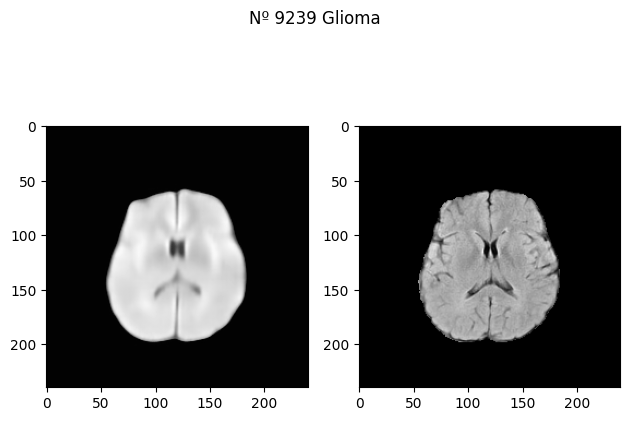

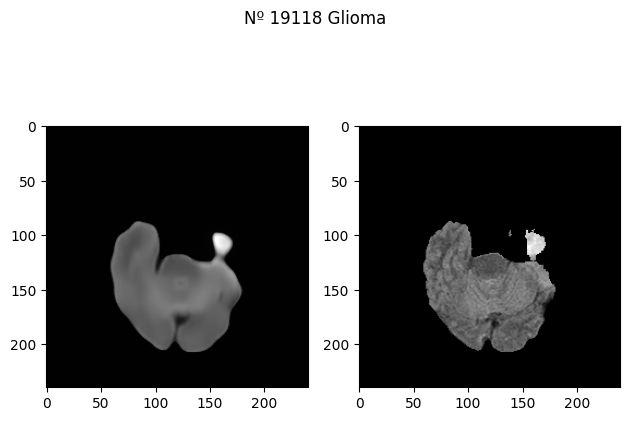

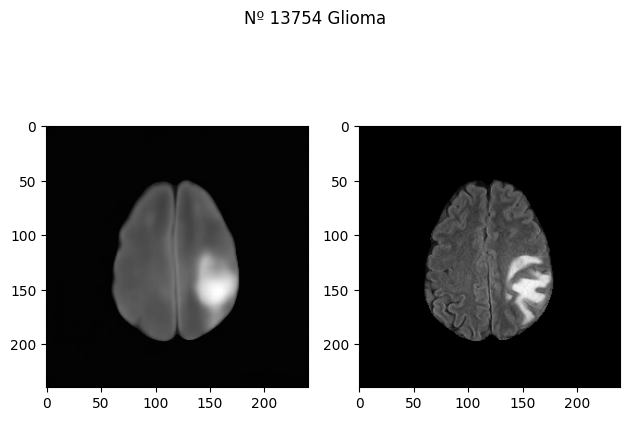

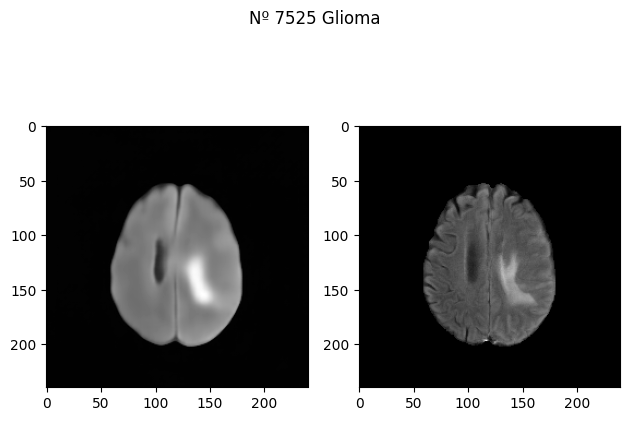

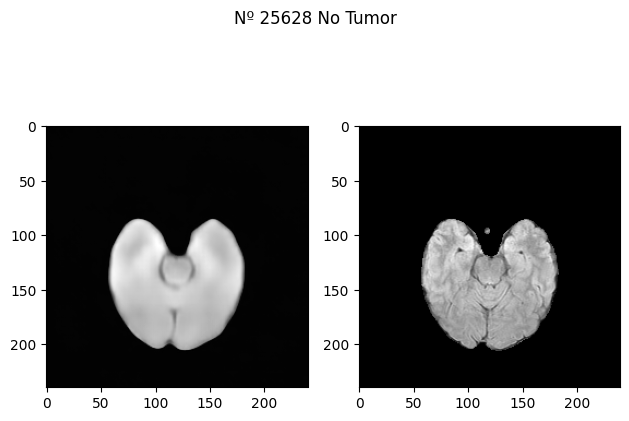

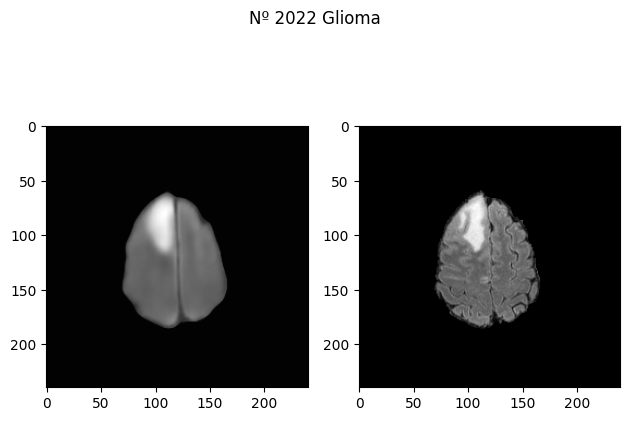

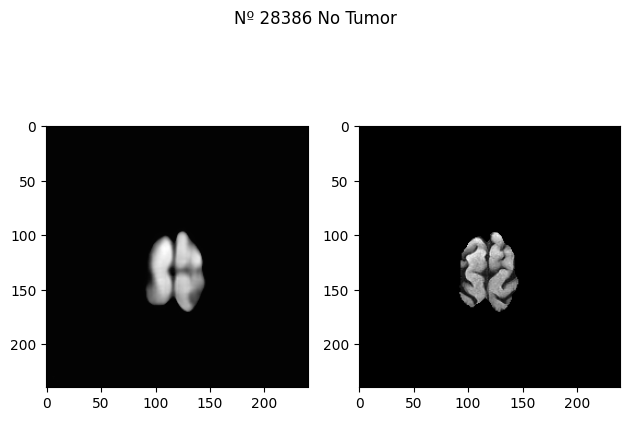

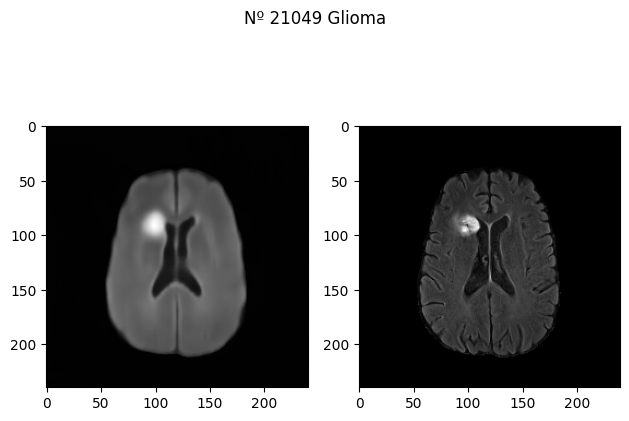

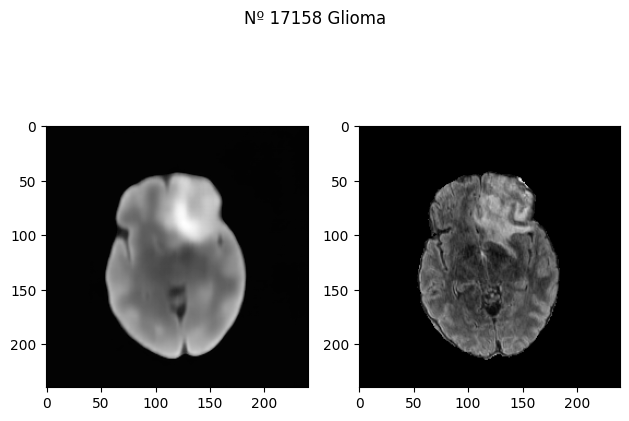

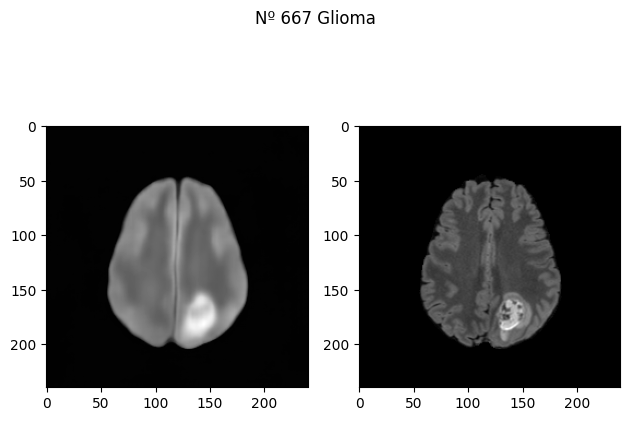

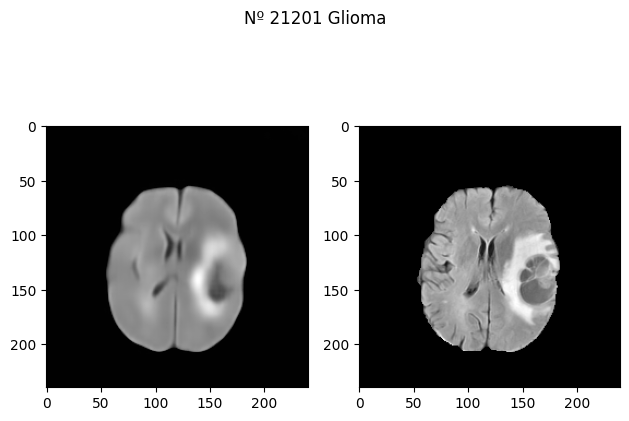

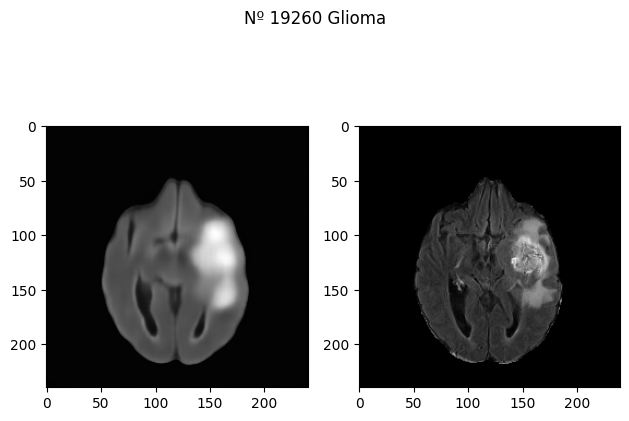

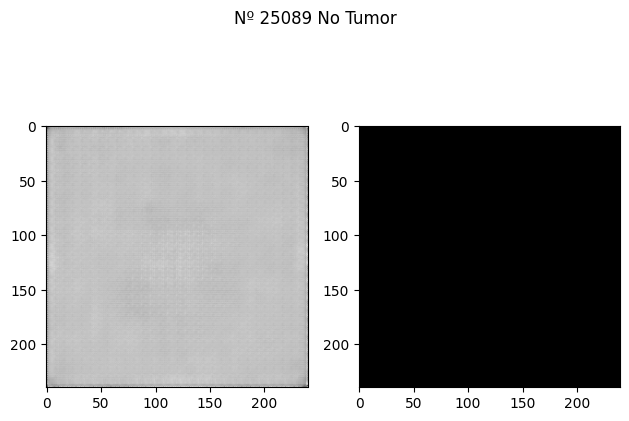

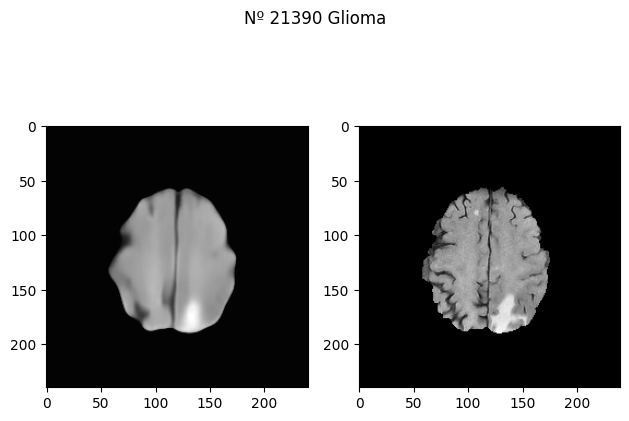

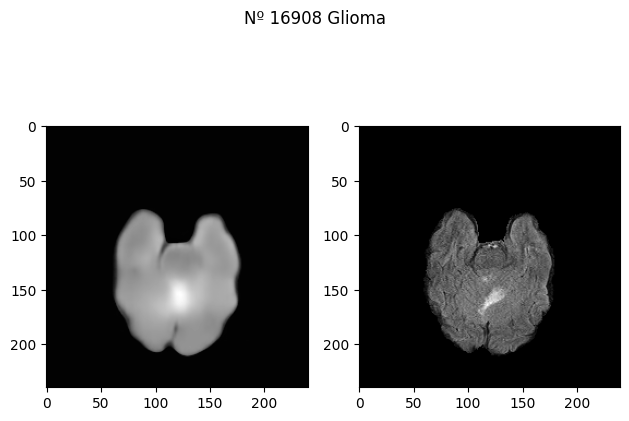

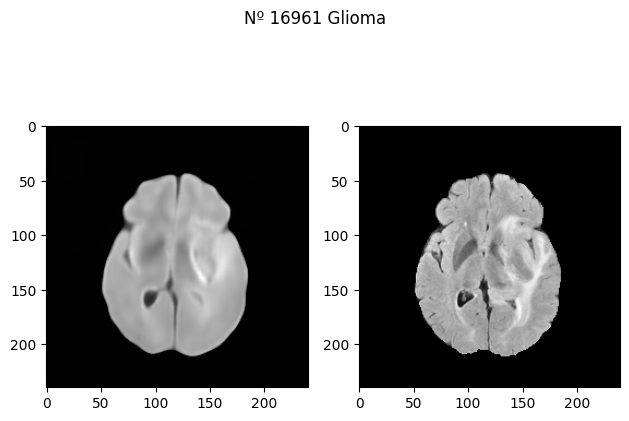

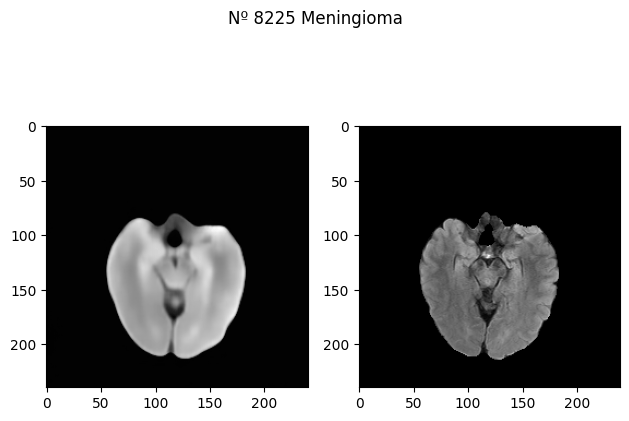

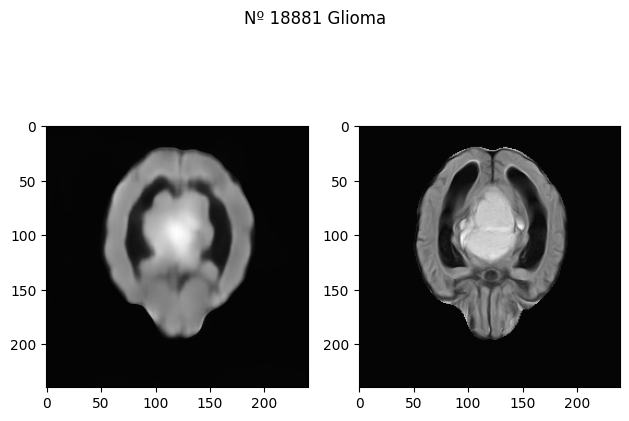

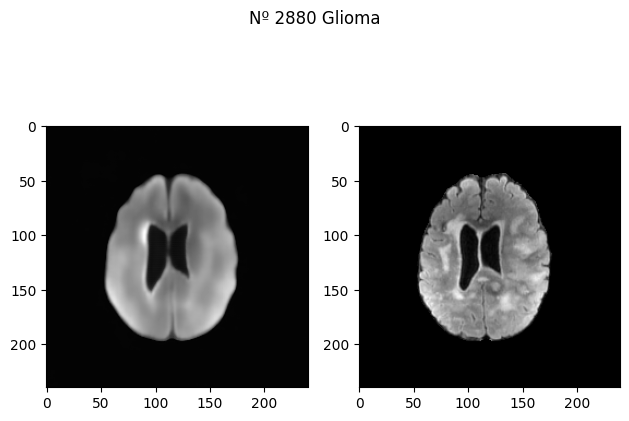

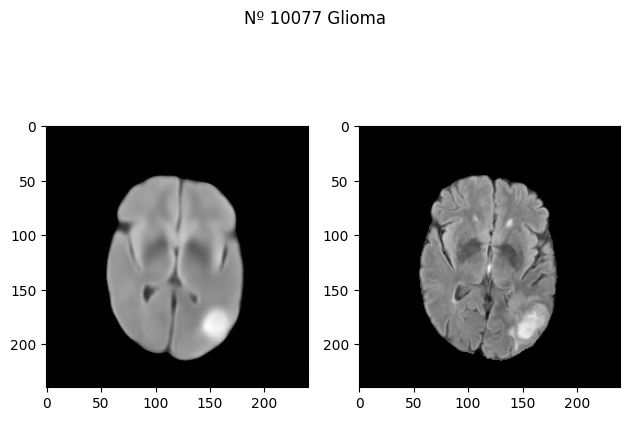

In [16]:
visualizar_imgs()